In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import datetime
import random
import copy
from tqdm import tqdm

# import sklearn
from sklearn.linear_model import LinearRegression, LassoLarsIC, LassoCV, Ridge, LogisticRegression, LogisticRegressionCV
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.svm import SVR, SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectFromModel, SequentialFeatureSelector
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.metrics import confusion_matrix  #, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

from scipy.stats import multivariate_normal, bernoulli

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.distributions import Bernoulli
# from torchsummary import summary

import multiprocessing as mp


import os
import sys

In [2]:
# ===================== linear model with intersection =====================================================
def generate_data(m=100, n=20, signal=1, sigma=5, num_support=8, seed=1):
    "Generates data matrix X and observations Y."
    np.random.seed(seed)
    
    X = np.random.randn(m,n)
    X_s = X[:, :num_support]
    beta_star = np.array([signal] * 6)
    
    Y = beta_star[0] * X_s[:, 0] + beta_star[1] * X_s[:, 1] * X_s[:, 2] + \
        beta_star[2] * X_s[:, 3] + beta_star[3] * X_s[:, 4] * X_s[:, 5] + beta_star[4] * X_s[:, 6] + \
        beta_star[5] * X_s[:, 7] + np.random.normal(0, sigma, size=m)
    return X, Y, beta_star, np.diag(np.ones(n))

In [3]:
# ==============================================================================================
def get_data(x, y, batch_size=32):
#     x = StandardScaler(with_mean=True, with_std=True).fit_transform(x)
    sample_size = x.shape[0]
    idx = np.random.choice(range(sample_size), batch_size, replace=False)
    return x[idx, :], y[idx, np.newaxis]



class Actor(nn.Module):
    def __init__(self, obs_dim, action_dim):
        '''
        obs_dim: dim_x or (dim_x + dim_y)
        action_dim: dim_x
        '''
        super(Actor, self).__init__()
        
        
        self.fc1 = nn.Linear(in_features=obs_dim, out_features=256)
        self.fc2 = nn.Linear(256, action_dim)
        
    def forward(self, obs):
        obs = torch.tensor(obs, dtype=torch.float)
        logits = F.relu(self.fc1(obs))
        logits = self.fc2(logits)
        
        m = Bernoulli(logits=logits)
        
        actions = m.sample()
        log_probs = m.log_prob(actions)
        entropy = m.entropy()
        
        return actions, log_probs, entropy

## mlp reward

In [4]:
def compute_reward(X_train, Y_train, X_test, Y_test, actions, hiddens=(128, ), num_iter=500, lr=1e-3, batch_size='auto', dictionary=dict()):
    reward_list = []
    for i, action in enumerate(actions):
        
        idx = np.where(action == 1)[0]
        
        if tuple(idx) in dictionary:
            reward_list.append(dictionary[tuple(idx)])
        else:
            X_select = X_train[:, idx]        
            reg_clf = MLPRegressor(hidden_layer_sizes=hiddens, random_state=i, learning_rate='adaptive', batch_size=batch_size,
                                     learning_rate_init=lr, max_iter=num_iter, tol=1e-3, alpha=0.01, early_stopping=True)
#             reg_clf = LinearRegression(fit_intercept=False)
#             reg_clf = Ridge(alpha=0.05, fit_intercept=False)
            # reg_clf = RandomForestRegressor(n_estimators=50)
#             reg_clf = ExtraTreesRegressor(n_estimators=50)
#             reg_clf = MLPClassifier(hidden_layer_sizes=hiddens, random_state=i, learning_rate='adaptive', batch_size=batch_size,
#                                      learning_rate_init=lr, max_iter=num_iter, tol=1e-3, alpha=0.01, early_stopping=True)
            # reg_clf = RandomClassifier(n_estimators=50, max_depth=5)
#             reg_clf = ExtraTreesClassifier(n_estimators=50, max_depth=5)
            reg_clf.fit(X_select, Y_train)
            X_select = X_test[:, idx] 
            score = reg_clf.score(X_select, Y_test)
            # mse = np.mean((Y_test - regressor.predict(X_select))**2)
            dictionary[tuple(idx)] = score
            reward_list.append(score)
        
    return np.array(reward_list)

In [10]:
# start = time.time()
# training steps
m = 200                  # linear case, n=300, 样本量为100可以，但是当变成200时就不行了...
n = 50
signal = 1
sigma = 0.5
num_support = 8
batch_size = 64

seed = 6
np.random.seed(seed)
torch.manual_seed(seed)

X, Y, beta_star, cov = generate_data(m, n, signal, sigma, num_support, seed=seed)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=seed)


# actor = Actor(obs_dim=n, action_dim=n)
# actor_optimizer = optim.Adam(actor.parameters(), lr=1e-3)   # 不能太大了，1e-2就不行



r_list = []
r_baseline = 0
dictionary = dict()
theta = np.zeros(n) + 0.5
p_list = []
w_norm = []

for step in range(100):               # hierarchical # feature=50, 150,    quadratic mlp 256, 120
#     print('step: ', step)
    
    p_list.append(theta)
#     idx_select = np.where(theta > 0.9)[0]
    
    actions = np.zeros((batch_size, n))
    p = torch.from_numpy(theta)
    for i in range(batch_size):
        action = torch.bernoulli(p)
        if action.sum == 0:
            idx = np.random.randint(0, n, int(n/3))
            action[idx] = 1
        actions[i, :] = action.numpy()
#         idx = np.random.choice(np.where(action == 1)[0], 5, replace=False)
#         tmp = np.zeros(n)
#         tmp[idx] = 1
#         tmp[idx_select] = 1
#         actions[i, :] = tmp
        
    
    
    rewards = compute_reward(x_train, y_train, x_test, y_test, actions, hiddens=(128, ), num_iter=200, lr=1e-2, batch_size='auto', dictionary=dictionary)
    r_list.append(rewards.mean())
#     print(f'average reward: {rewards.mean()}')
#     rewards = torch.tensor(rewards, dtype=torch.float32)
    
#     r_baseline = 0.95 * r_baseline + 0.05 * rewards.mean()
#     rewards -= r_baseline
    # sampled natural policy gradient
    log_pi_grad = actions / theta - (1 - actions)/(1 - theta)
#     log_pi_grad = log_pi_grad.numpy()
    
    reg = Ridge(alpha=0.05)                    # 非常意外，如果使用了fit_intercept=False, 结果反而不好，而且使用linearRegressor也不行
    reg.fit(log_pi_grad, rewards)
    w = reg.coef_
    
    w_norm.append(np.linalg.norm(w))
    
    theta = theta + 1 * w    
    theta = np.clip(theta, 0.02, 0.98)
    
#     if step > 100:
#         theta = np.where(theta < 0.4, 0.02, theta)
        


#     if step > 6:
#         if (abs(r_list[-1] - r_list[-2]) < 1e-3) & (abs(r_list[-2] - r_list[-3]) < 1e-3) \
#             & (abs(r_list[-3] - r_list[-4]) < 1e-3) & (abs(r_list[-4] - r_list[-5]) < 1e-3):
#             print(f'converge at step {step}')
#             break

#     if np.linalg.norm(theta - p_list[-1]) < 1e-3:
#         print(f'converge at step {step}')
#         break

# end = time.time()

# print(datetime.timedelta(seconds=end - start))

[0.98 0.58 0.68 0.97 0.98 0.98 0.98 0.98 0.63 0.15 0.34 0.41 0.54 0.36
 0.14 0.95 0.48 0.78 0.51 0.18 0.42 0.38 0.7  0.41 0.2  0.58 0.76 0.22
 0.74 0.2  0.37 0.33 0.36 0.38 0.22 0.14 0.02 0.51 0.55 0.7  0.32 0.39
 0.13 0.65 0.09 0.85 0.12 0.29 0.6  0.25]
[ 0  3  4  5  6  7 15]
[ 0  7  6  4  5  3 15 45 17 26 28 22 39  2 43  8 48  1 25 38 12 37 18 16
 20 11 23 41 21 33 30 32 13 10 31 40 47 49 27 34 29 24 19  9 35 14 42 46
 44 36]


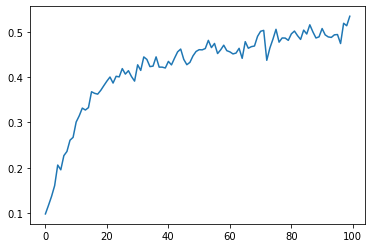

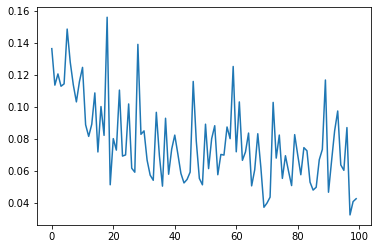

In [11]:
plt.plot(r_list)
print(np.round(theta, 2))
print(np.where(theta > 0.90)[0])
print(np.argsort(theta)[::-1])
plt.figure()
plt.plot(w_norm)

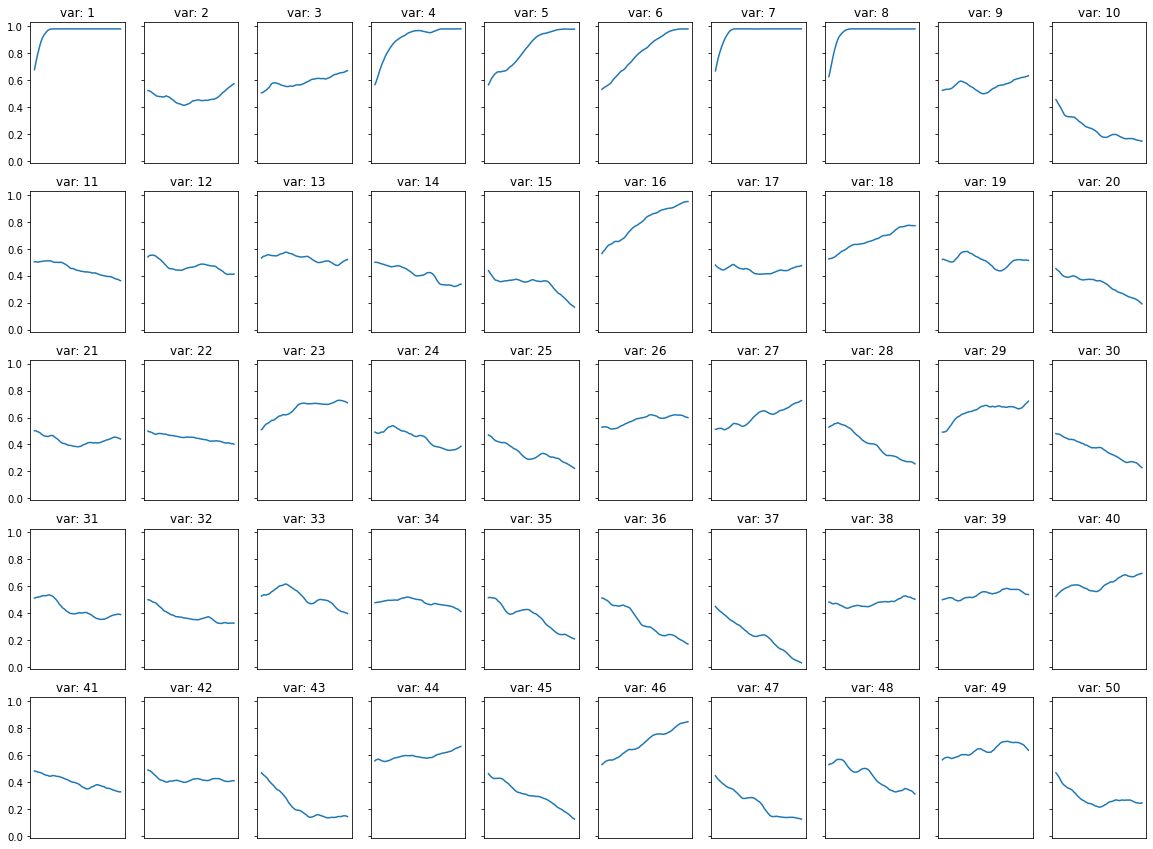

In [12]:
probs = np.array(p_list)
fig, axes = plt.subplots(int(n/10+0.9), 10, figsize=(20, 15), sharex=False, sharey=True)
# plt.subplots_adjust(
# top=0.965,
# bottom=0.09,
# left=0.03,
# right=0.83,
# hspace=0.52,
# wspace=0.18)
# fig.tight_layout()
num = 0
for i in range(int(n/10+0.9)):
    for j in range(10):
        axes[i, j].plot(pd.Series(np.array(probs)[:, num]).rolling(10).mean())
        axes[i, j].set_title(f'var: {num+1}')
        if i != int(n/8)-1: axes[i, j].set_xticks([]) 
        num += 1

In [13]:
print('npg')
print(np.where(theta > 0.90)[0] + 1)

print('lasso_aic')
lasso_aic = LassoLarsIC(criterion='aic', fit_intercept=False, normalize=False)
lasso_aic.fit(X, Y)
print(np.where(lasso_aic.coef_ != 0)[0] + 1)

print('lasso_bic')
from sklearn.linear_model import Lasso, LassoLarsIC, LassoCV
lasso_bic = LassoLarsIC(criterion='bic', fit_intercept=False, normalize=False)
lasso_bic.fit(X, Y)
print(np.where(lasso_bic.coef_ != 0)[0] + 1)

print('lasso_cv')
lasso_cv = LassoCV(cv=5, fit_intercept=False)
lasso_cv.fit(X, Y)
print(np.where(lasso_cv.coef_ != 0)[0] + 1)

print('random_forest')
rf = RandomForestRegressor(max_depth=5, random_state=seed)    
rf.fit(X, Y)
sfm = SelectFromModel(rf, prefit=True)
print(np.arange(n)[sfm.get_support()] + 1)

npg
[ 1  4  5  6  7  8 16]
lasso_aic
[ 1  3  4  5  7  8 10 16 23 29 32 44 46]
lasso_bic
[ 1  4  7  8 44]
lasso_cv
[ 1  3  4  5  7  8 16 23 29 32 44 46]
random_forest
[ 1  3  4  7  8 44]


## linear reward

In [47]:
def compute_reward(X_train, Y_train, X_test, Y_test, actions, hiddens=(128, ), num_iter=500, lr=1e-3, batch_size='auto', dictionary=dict()):
    reward_list = []
    for i, action in enumerate(actions):
        
        idx = np.where(action == 1)[0]
        
        if tuple(idx) in dictionary:
            reward_list.append(dictionary[tuple(idx)])
        else:
            X_select = X_train[:, idx]        
#             reg_clf = MLPRegressor(hidden_layer_sizes=hiddens, random_state=i, learning_rate='adaptive', batch_size=batch_size,
#                                      learning_rate_init=lr, max_iter=num_iter, tol=1e-3, alpha=0.01, early_stopping=True)
            reg_clf = LinearRegression(fit_intercept=False)
#             reg_clf = Ridge(alpha=0.05, fit_intercept=False)
            # reg_clf = RandomForestRegressor(n_estimators=50)
#             reg_clf = ExtraTreesRegressor(n_estimators=50)
#             reg_clf = MLPClassifier(hidden_layer_sizes=hiddens, random_state=i, learning_rate='adaptive', batch_size=batch_size,
#                                      learning_rate_init=lr, max_iter=num_iter, tol=1e-3, alpha=0.01, early_stopping=True)
            # reg_clf = RandomClassifier(n_estimators=50, max_depth=5)
#             reg_clf = ExtraTreesClassifier(n_estimators=50, max_depth=5)
            reg_clf.fit(X_select, Y_train)
            X_select = X_test[:, idx] 
            score = reg_clf.score(X_select, Y_test)
            # mse = np.mean((Y_test - regressor.predict(X_select))**2)
            dictionary[tuple(idx)] = score
            reward_list.append(score)
        
    return np.array(reward_list)

In [50]:
for i in range(10):
    # start = time.time()
    # training steps
    m = 200                  # linear case, n=300, 样本量为100可以，但是当变成200时就不行了...
    n = 50
    signal = 1
    sigma = 0.5
    num_support = 8
    batch_size = 64

    seed = 6
    np.random.seed(seed)
    torch.manual_seed(seed)

    X, Y, beta_star, cov = generate_data(m, n, signal, sigma, num_support, seed=seed)

    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=seed)


    # actor = Actor(obs_dim=n, action_dim=n)
    # actor_optimizer = optim.Adam(actor.parameters(), lr=1e-3)   # 不能太大了，1e-2就不行



    r_list = []
    r_baseline = 0
    dictionary = dict()
    theta = np.zeros(n) + 0.5
    p_list = []
    w_norm = []

    for step in range(100):               # hierarchical # feature=50, 150,    quadratic mlp 256, 120
    #     print('step: ', step)

        p_list.append(theta)
    #     idx_select = np.where(theta > 0.9)[0]

        actions = np.zeros((batch_size, n))
        p = torch.from_numpy(theta)
        for i in range(batch_size):
            action = torch.bernoulli(p)
            if action.sum == 0:
                idx = np.random.randint(0, n, int(n/3))
                action[idx] = 1
            actions[i, :] = action.numpy()
    #         idx = np.random.choice(np.where(action == 1)[0], 5, replace=False)
    #         tmp = np.zeros(n)
    #         tmp[idx] = 1
    #         tmp[idx_select] = 1
    #         actions[i, :] = tmp



        rewards = compute_reward(x_train, y_train, x_test, y_test, actions, hiddens=(128, ), num_iter=200, lr=1e-2, batch_size='auto', dictionary=dictionary)
        r_list.append(rewards.mean())
    #     print(f'average reward: {rewards.mean()}')
    #     rewards = torch.tensor(rewards, dtype=torch.float32)

    #     r_baseline = 0.95 * r_baseline + 0.05 * rewards.mean()
    #     rewards -= r_baseline
        # sampled natural policy gradient
        log_pi_grad = actions / theta - (1 - actions)/(1 - theta)
    #     log_pi_grad = log_pi_grad.numpy()

        reg = Ridge(alpha=0.05)                    # 非常意外，如果使用了fit_intercept=False, 结果反而不好，而且使用linearRegressor也不行
        reg.fit(log_pi_grad, rewards)
        w = reg.coef_

        w_norm.append(np.linalg.norm(w))

        theta = theta + 1 * w    
        theta = np.clip(theta, 0.02, 0.98)

    #     if step > 100:
    #         theta = np.where(theta < 0.4, 0.02, theta)



    #     if step > 6:
    #         if (abs(r_list[-1] - r_list[-2]) < 1e-3) & (abs(r_list[-2] - r_list[-3]) < 1e-3) \
    #             & (abs(r_list[-3] - r_list[-4]) < 1e-3) & (abs(r_list[-4] - r_list[-5]) < 1e-3):
    #             print(f'converge at step {step}')
    #             break

    #     if np.linalg.norm(theta - p_list[-1]) < 1e-3:
    #         print(f'converge at step {step}')
    #         break

    # end = time.time()

    # print(datetime.timedelta(seconds=end - start))

In [51]:
120/10

12.0

In [49]:
print('npg')
print(np.where(theta > 0.90)[0] + 1)

print('lasso_aic')
lasso_aic = LassoLarsIC(criterion='aic', fit_intercept=False, normalize=False)
lasso_aic.fit(X, Y)
print(np.where(lasso_aic.coef_ != 0)[0] + 1)

print('lasso_bic')
from sklearn.linear_model import Lasso, LassoLarsIC, LassoCV
lasso_bic = LassoLarsIC(criterion='bic', fit_intercept=False, normalize=False)
lasso_bic.fit(X, Y)
print(np.where(lasso_bic.coef_ != 0)[0] + 1)

print('lasso_cv')
lasso_cv = LassoCV(cv=5, fit_intercept=False)
lasso_cv.fit(X, Y)
print(np.where(lasso_cv.coef_ != 0)[0] + 1)

print('random_forest')
rf = RandomForestRegressor(max_depth=5, random_state=seed)    
rf.fit(X, Y)
sfm = SelectFromModel(rf, prefit=True)
print(np.arange(n)[sfm.get_support()] + 1)

npg
[1 4 7 8]
lasso_aic
[ 1  3  4  5  7  8 10 16 23 29 32 44 46]
lasso_bic
[ 1  4  7  8 44]
lasso_cv
[ 1  3  4  5  7  8 16 23 29 32 44 46]
random_forest
[ 1  3  4  7  8 44]


## lasso types

In [38]:
for i in range(100):
    lasso_aic = LassoLarsIC(criterion='aic', fit_intercept=False, normalize=False)
    lasso_aic.fit(X, Y)

In [43]:
2.45/100*1000

24.5

In [39]:
for i in range(100):
    lasso_bic = LassoLarsIC(criterion='bic', fit_intercept=False, normalize=False)
    lasso_bic.fit(X, Y)

In [46]:
2.55/100*1000

25.5

In [40]:
for i in range(100):
    lasso_cv = LassoCV(cv=5, fit_intercept=False)
    lasso_cv.fit(X, Y)

In [44]:
23.1/100*1000

231.0

## random forest

In [41]:
for i in range(100):
    rf = RandomForestRegressor(max_depth=5, random_state=seed)    
    rf.fit(X, Y)

In [45]:
53.3/100*1000

532.9999999999999

## time comparison

In [ ]:
8mins, 12s, 24.5ms, 25.5ms, 231ms, 532ms